In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline, BSpline

In [2]:
cd '/home/sever2users/Desktop/Animesh-Renanse/RNN CONTROLLER'

/home/sever2users/Desktop/Animesh-Renanse/RNN CONTROLLER


In [3]:
import MatrixNTM

In [4]:
cd 'SavedModels/RNNMatNTM_Copy1/Train1'

/home/sever2users/Desktop/Animesh-Renanse/RNN CONTROLLER/SavedModels/RNNMatNTM_Copy1/Train1


In [5]:
MNTM = torch.load('MNTM.pth')

In [6]:
MNTM.count_parameters()

+-------------------------------------------+------------+
|                  Modules                  | Parameters |
+-------------------------------------------+------------+
|      Controller.RNN.0.Connections.Up      |    225     |
|      Controller.RNN.0.Connections.Vp      |    225     |
|      Controller.RNN.0.Connections.Uq      |     75     |
|      Controller.RNN.0.Connections.Vq      |     75     |
|      Controller.RNN.0.Connections.Ur      |     90     |
|      Controller.RNN.0.Connections.Vr      |     90     |
|       Controller.RNN.0.Connections.B      |    225     |
|      Controller.RNN.1.Connections.Up      |    225     |
|      Controller.RNN.1.Connections.Vp      |    225     |
|      Controller.RNN.1.Connections.Uq      |     75     |
|      Controller.RNN.1.Connections.Vq      |     75     |
|      Controller.RNN.1.Connections.Ur      |     90     |
|      Controller.RNN.1.Connections.Vr      |     90     |
|       Controller.RNN.1.Connections.B      |    225    

4121

In [7]:
BATCH_SIZE = 16
INPUT_DIMS  = [5,5]
DEVICE='cuda:0'


In [8]:
def MatrixCopyDataGen(batch_size = 32, item_size = [4,5], timesteps = 2, device = None):
    
    assert item_size[0] == item_size[1] - 1
    
    pre_content = torch.rand([batch_size, item_size[0]+1, item_size[1]*timesteps])
    
    pre_content[:,:-1,:][pre_content[:,:-1,:] > 0.5] = 1.0
    pre_content[:,-1,:] = 0.0
    pre_content[pre_content != 1] = 0.0
        
    limiter = torch.zeros([batch_size, item_size[0]+1, item_size[1]])
    limiter[:,-1,:] = 1.0
    #response_sheet = torch.zeros_like(pre_content)
    question_ = torch.cat([pre_content, limiter], dim = 2) 
    question = question_ #+ torch.randn(question_.shape)*1e-3#np.random.normal(loc=0,scale=1e-3,size=question_.shape)
    
    return question.to(device), pre_content.to(device)

def Bit_Seq_Error(output , target, batch_size, sequence_length):
    bit_output = output.detach().clone()
    bit_output[bit_output >= 0.5] = 1.0
    bit_output[bit_output != 1.0] = 0.0
    bit_error = torch.sum((torch.abs(target - bit_output)) )/(batch_size*sequence_length)
    return bit_error


loss_func = torch.nn.BCELoss()

In [9]:
def RunOneEpoch(num_t=2):
    i=0

    #int( torch.randint(low=1, high=21, size=[], device=DEVICE) )

    inp, out = MatrixCopyDataGen(BATCH_SIZE,[INPUT_DIMS[0]-1, INPUT_DIMS[1]],num_t,DEVICE)

    response_sheet = torch.zeros_like(out)

    print("Epoch: ",i)
    print("--->Sequence Length: ",int(num_t))

    MNTM.HiddenReset()

    MNTM.zero_grad()

    #Feeding the sequence
    ReadW_List = []
    WriteW_List = []
    Memories = []
    for t in range(1,num_t+2):    
        _ = MNTM(inp[:,:,(t-1)*INPUT_DIMS[1]:t*INPUT_DIMS[1]])
        ReadW_List.append(MNTM.Controller.HO_Out[1][0][0].reshape(-1,1).detach().cpu())
        #                                        ^Read ^Batch
        WriteW_List.append(MNTM.Controller.HO_Out[2][0][0].reshape(-1,1).detach().cpu())
        Memories.append(MNTM.MemoryUnit.Memory[0].detach().cpu())
    #Taking Output from controller now, for backprop
    output = []

    for t in range(1,num_t+1):
        MNTM_out = MNTM(response_sheet[:,:,(t-1)*INPUT_DIMS[1]:t*INPUT_DIMS[1]])
        output.append(MNTM_out)
        ReadW_List.append(MNTM.Controller.HO_Out[1][0][0].reshape(-1,1).detach().cpu())
        #                                        ^Read ^Batch
        WriteW_List.append(MNTM.Controller.HO_Out[2][0][0].reshape(-1,1).detach().cpu())
        Memories.append(MNTM.MemoryUnit.Memory[0].detach().cpu())

    res = torch.cat(output, dim=2)

    loss = loss_func(res, out)
    bse = Bit_Seq_Error(res, out, BATCH_SIZE, num_t)

    print("----->Loss: {}".format(loss))
    print("----->Sequence Bit Error: {}".format(bse))
    

    inp_ = inp.clone().cpu()
    out_ = out.clone().cpu().detach()
    res_ = res.clone().cpu().detach()
    
    return bse,inp_, out_, res_, WriteW_List, ReadW_List, Memories

In [10]:
num_t = 5
_,inp, out, res, WriteW_List, ReadW_List, Mems = RunOneEpoch(num_t)

Epoch:  0
--->Sequence Length:  5
----->Loss: 9.238721454529752e-10
----->Sequence Bit Error: 0.0


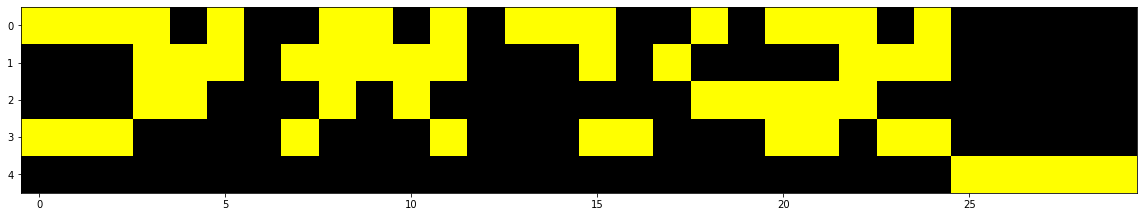

In [11]:
plt.figure(figsize=(20,12))
plt.imshow(inp[0][:,:],cmap='gnuplot')
plt.savefig('Input1.svg')

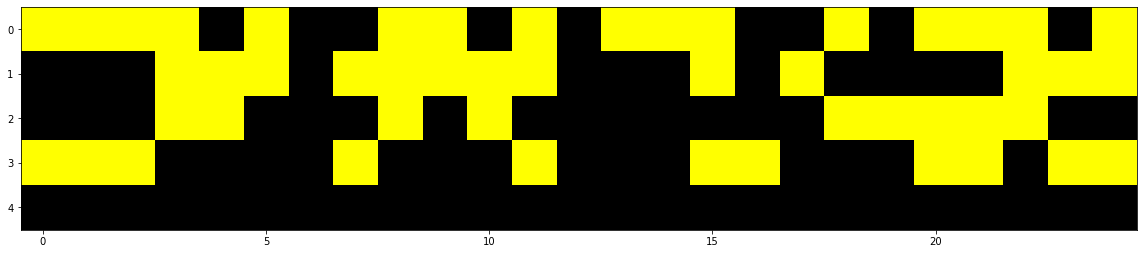

In [12]:
plt.figure(figsize=(20,12))
plt.imshow(res[0], cmap='gnuplot')
plt.savefig('Output1.svg')

In [13]:
READW = torch.cat(ReadW_List,1)
WRITEW = torch.cat(WriteW_List,1)

In [14]:
JOINTW = torch.cat([WRITEW[:,:num_t+1], READW[:,num_t+1:]],1)

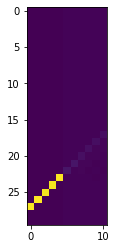

In [15]:
plt.imshow(WRITEW[:30,:])
plt.savefig('WRITEW.svg')

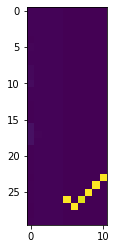

In [16]:
plt.imshow(READW[:30,:])
plt.savefig('READW.svg')

In [17]:
MEM = torch.cat(Mems, -1)

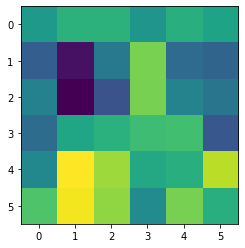

In [18]:
# plt.figure(figsize=(20,12))
i=3
plt.imshow(torch.cat(torch.split(Mems[i], [1 for _ in range(120)], dim=0 ), dim=-1).squeeze()[:,90-i*6:96-i*6])

<Figure size 1440x864 with 0 Axes>

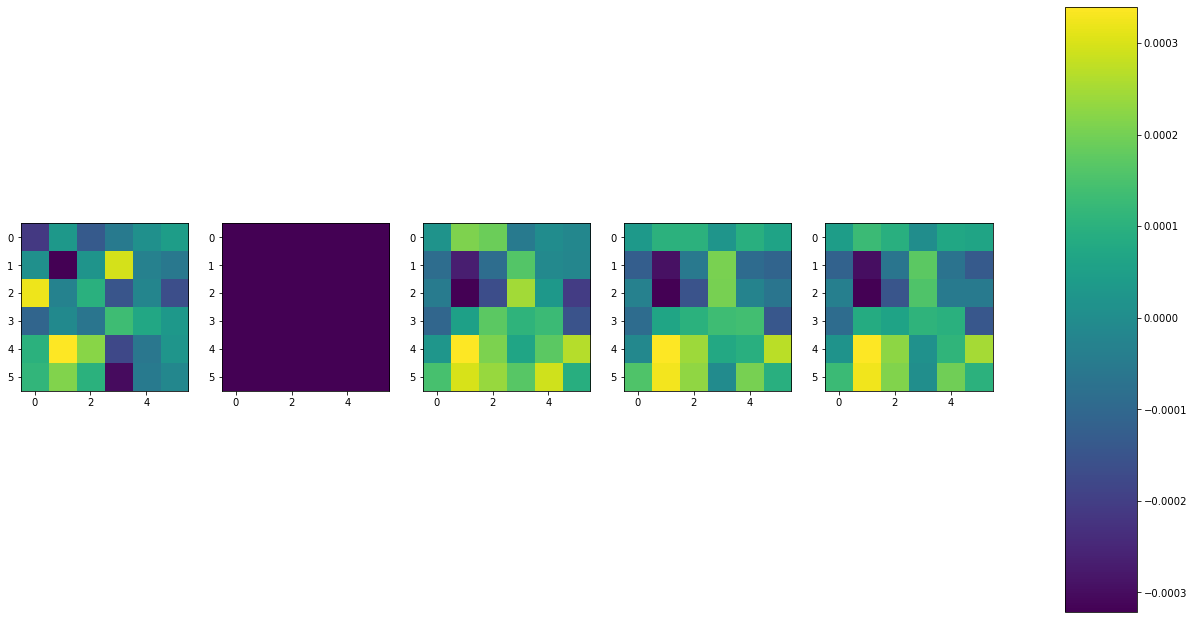

In [19]:
plt.figure(figsize=(20,12))

# plt.imshow(torch.cat(torch.split(Mems[4], [1 for _ in range(120)], dim=0 ), dim=-1).squeeze()[:,:100])

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20,12))
for i,ax in enumerate(axes.flat):
    im = ax.imshow(torch.cat(torch.split(Mems[i], [1 for _ in range(120)], dim=0 ), dim=-1).squeeze()[:,90-i*6:96-i*6])

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.savefig('mem_repres.svg')

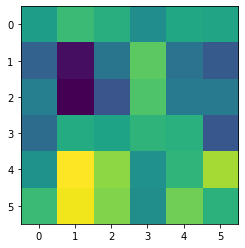

In [20]:
#plt.figure(figsize=(20,12))
i=1
mems = []
for i in range(5):
    a = torch.cat(torch.split(Mems[i], [1 for _ in range(120)], dim=0 ), dim=-1).squeeze()
    #plt.imshow(a[:,30-i*6:36-i*6])
    plt.imshow(a[:,72-i*6:78-i*6])
    mems.append(a[:,72-i*6:78-i*6])
    #plt.colorbar()
    #plt.savefig('MemContent{}.svg'.format(i))

## To show the increase in BSE with increasing length of input matrix sequence

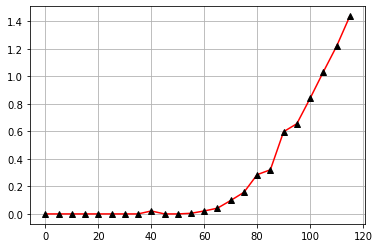

In [81]:
x = [i for i in range(0,120,5)]
y = [BSEs[i] for i in x]
plt.plot(x,y,'red')
plt.plot(x,y,'^',c='black')
plt.grid(True)
plt.savefig('high_BSEs.svg')
# plt.plot(BSEs[:120],'o')

In [21]:
MultiBSEs = []
seq_lengths = [i for i in range(1,120)]
for i in range(5):
    BSEs = []
    for l in seq_lengths:
        bse,_,_,_,_,_,_ = RunOneEpoch(l)
        BSEs.append(float(bse))
    MultiBSEs.append(BSEs)

Epoch:  0
--->Sequence Length:  1
----->Loss: 4.965439984516706e-06
----->Sequence Bit Error: 0.0
Epoch:  0
--->Sequence Length:  2
----->Loss: 2.5779232970535304e-08
----->Sequence Bit Error: 0.0
Epoch:  0
--->Sequence Length:  3
----->Loss: 5.280998607304355e-07
----->Sequence Bit Error: 0.0
Epoch:  0
--->Sequence Length:  4
----->Loss: 8.233389081624409e-08
----->Sequence Bit Error: 0.0
Epoch:  0
--->Sequence Length:  5
----->Loss: 9.152579139026784e-08
----->Sequence Bit Error: 0.0
Epoch:  0
--->Sequence Length:  6
----->Loss: 4.718702095729554e-10
----->Sequence Bit Error: 0.0
Epoch:  0
--->Sequence Length:  7
----->Loss: 7.769945575830661e-09
----->Sequence Bit Error: 0.0
Epoch:  0
--->Sequence Length:  8
----->Loss: 0.005386240780353546
----->Sequence Bit Error: 0.046875
Epoch:  0
--->Sequence Length:  9
----->Loss: 7.285013703395293e-10
----->Sequence Bit Error: 0.0
Epoch:  0
--->Sequence Length:  10
----->Loss: 2.995160741647851e-08
----->Sequence Bit Error: 0.0
Epoch:  0
--->

----->Loss: 0.03529787436127663
----->Sequence Bit Error: 0.2151898741722107
Epoch:  0
--->Sequence Length:  80
----->Loss: 0.033125072717666626
----->Sequence Bit Error: 0.20156250894069672
Epoch:  0
--->Sequence Length:  81
----->Loss: 0.0397663488984108
----->Sequence Bit Error: 0.24382716417312622
Epoch:  0
--->Sequence Length:  82
----->Loss: 0.041772715747356415
----->Sequence Bit Error: 0.2522865831851959
Epoch:  0
--->Sequence Length:  83
----->Loss: 0.053800154477357864
----->Sequence Bit Error: 0.3192771077156067
Epoch:  0
--->Sequence Length:  84
----->Loss: 0.050142232328653336
----->Sequence Bit Error: 0.2976190447807312
Epoch:  0
--->Sequence Length:  85
----->Loss: 0.05298399552702904
----->Sequence Bit Error: 0.30441176891326904
Epoch:  0
--->Sequence Length:  86
----->Loss: 0.05705336853861809
----->Sequence Bit Error: 0.32485464215278625
Epoch:  0
--->Sequence Length:  87
----->Loss: 0.07589241862297058
----->Sequence Bit Error: 0.395114928483963
Epoch:  0
--->Sequenc

----->Loss: 0.001959098968654871
----->Sequence Bit Error: 0.021381579339504242
Epoch:  0
--->Sequence Length:  39
----->Loss: 7.554485819127876e-07
----->Sequence Bit Error: 0.0
Epoch:  0
--->Sequence Length:  40
----->Loss: 2.513940444259788e-06
----->Sequence Bit Error: 0.0
Epoch:  0
--->Sequence Length:  41
----->Loss: 1.2733577932522167e-05
----->Sequence Bit Error: 0.0
Epoch:  0
--->Sequence Length:  42
----->Loss: 1.8073133105644956e-06
----->Sequence Bit Error: 0.0
Epoch:  0
--->Sequence Length:  43
----->Loss: 3.247418817409198e-06
----->Sequence Bit Error: 0.0
Epoch:  0
--->Sequence Length:  44
----->Loss: 7.879288205003832e-06
----->Sequence Bit Error: 0.0
Epoch:  0
--->Sequence Length:  45
----->Loss: 3.889996878569946e-05
----->Sequence Bit Error: 0.0
Epoch:  0
--->Sequence Length:  46
----->Loss: 0.00012495140254031867
----->Sequence Bit Error: 0.0
Epoch:  0
--->Sequence Length:  47
----->Loss: 1.9673256247187965e-05
----->Sequence Bit Error: 0.0
Epoch:  0
--->Sequence Le

----->Loss: 0.2949027419090271
----->Sequence Bit Error: 1.2438616752624512
Epoch:  0
--->Sequence Length:  113
----->Loss: 0.3201415538787842
----->Sequence Bit Error: 1.3606194257736206
Epoch:  0
--->Sequence Length:  114
----->Loss: 0.3330780565738678
----->Sequence Bit Error: 1.3722587823867798
Epoch:  0
--->Sequence Length:  115
----->Loss: 0.3485458493232727
----->Sequence Bit Error: 1.417934775352478
Epoch:  0
--->Sequence Length:  116
----->Loss: 0.3738679587841034
----->Sequence Bit Error: 1.5043103694915771
Epoch:  0
--->Sequence Length:  117
----->Loss: 0.3664909601211548
----->Sequence Bit Error: 1.4588675498962402
Epoch:  0
--->Sequence Length:  118
----->Loss: 0.39356619119644165
----->Sequence Bit Error: 1.5640889406204224
Epoch:  0
--->Sequence Length:  119
----->Loss: 0.41717827320098877
----->Sequence Bit Error: 1.621323585510254
Epoch:  0
--->Sequence Length:  1
----->Loss: 1.955142806764343e-06
----->Sequence Bit Error: 0.0
Epoch:  0
--->Sequence Length:  2
----->Lo

----->Loss: 0.017734257504343987
----->Sequence Bit Error: 0.128521129488945
Epoch:  0
--->Sequence Length:  72
----->Loss: 0.015108630992472172
----->Sequence Bit Error: 0.1111111119389534
Epoch:  0
--->Sequence Length:  73
----->Loss: 0.025151308625936508
----->Sequence Bit Error: 0.16523972153663635
Epoch:  0
--->Sequence Length:  74
----->Loss: 0.015409472398459911
----->Sequence Bit Error: 0.1182432472705841
Epoch:  0
--->Sequence Length:  75
----->Loss: 0.019520485773682594
----->Sequence Bit Error: 0.13583333790302277
Epoch:  0
--->Sequence Length:  76
----->Loss: 0.022966884076595306
----->Sequence Bit Error: 0.14884868264198303
Epoch:  0
--->Sequence Length:  77
----->Loss: 0.024003922939300537
----->Sequence Bit Error: 0.15097402036190033
Epoch:  0
--->Sequence Length:  78
----->Loss: 0.02712978795170784
----->Sequence Bit Error: 0.16506411135196686
Epoch:  0
--->Sequence Length:  79
----->Loss: 0.1363963931798935
----->Sequence Bit Error: 0.5537974834442139
Epoch:  0
--->Seq

----->Loss: 6.666984120329289e-08
----->Sequence Bit Error: 0.0
Epoch:  0
--->Sequence Length:  30
----->Loss: 7.786063633830054e-07
----->Sequence Bit Error: 0.0
Epoch:  0
--->Sequence Length:  31
----->Loss: 2.5932040443876758e-05
----->Sequence Bit Error: 0.0
Epoch:  0
--->Sequence Length:  32
----->Loss: 0.00028542333166114986
----->Sequence Bit Error: 0.00390625
Epoch:  0
--->Sequence Length:  33
----->Loss: 1.1453846582298866e-06
----->Sequence Bit Error: 0.0
Epoch:  0
--->Sequence Length:  34
----->Loss: 4.032585366076091e-06
----->Sequence Bit Error: 0.0
Epoch:  0
--->Sequence Length:  35
----->Loss: 1.5932938595142332e-06
----->Sequence Bit Error: 0.0
Epoch:  0
--->Sequence Length:  36
----->Loss: 1.4261210878885322e-07
----->Sequence Bit Error: 0.0
Epoch:  0
--->Sequence Length:  37
----->Loss: 2.593686758700642e-06
----->Sequence Bit Error: 0.0
Epoch:  0
--->Sequence Length:  38
----->Loss: 6.962342240512953e-07
----->Sequence Bit Error: 0.0
Epoch:  0
--->Sequence Length:  3

----->Loss: 0.20300406217575073
----->Sequence Bit Error: 0.947115421295166
Epoch:  0
--->Sequence Length:  105
----->Loss: 0.21321770548820496
----->Sequence Bit Error: 0.9648810029029846
Epoch:  0
--->Sequence Length:  106
----->Loss: 0.2185148447751999
----->Sequence Bit Error: 1.03125
Epoch:  0
--->Sequence Length:  107
----->Loss: 0.23854507505893707
----->Sequence Bit Error: 1.0776869058609009
Epoch:  0
--->Sequence Length:  108
----->Loss: 0.2426096647977829
----->Sequence Bit Error: 1.0792824029922485
Epoch:  0
--->Sequence Length:  109
----->Loss: 0.259566992521286
----->Sequence Bit Error: 1.1490825414657593
Epoch:  0
--->Sequence Length:  110
----->Loss: 0.2778613567352295
----->Sequence Bit Error: 1.1920454502105713
Epoch:  0
--->Sequence Length:  111
----->Loss: 0.2913552522659302
----->Sequence Bit Error: 1.255630612373352
Epoch:  0
--->Sequence Length:  112
----->Loss: 0.3088901937007904
----->Sequence Bit Error: 1.2717634439468384
Epoch:  0
--->Sequence Length:  113
---

----->Loss: 0.003269288456067443
----->Sequence Bit Error: 0.0307539701461792
Epoch:  0
--->Sequence Length:  64
----->Loss: 0.007629188243299723
----->Sequence Bit Error: 0.0654296875
Epoch:  0
--->Sequence Length:  65
----->Loss: 0.004380357917398214
----->Sequence Bit Error: 0.048076923936605453
Epoch:  0
--->Sequence Length:  66
----->Loss: 0.006199278868734837
----->Sequence Bit Error: 0.05018939450383186
Epoch:  0
--->Sequence Length:  67
----->Loss: 0.006744805723428726
----->Sequence Bit Error: 0.058768656104803085
Epoch:  0
--->Sequence Length:  68
----->Loss: 0.0074030389077961445
----->Sequence Bit Error: 0.0625
Epoch:  0
--->Sequence Length:  69
----->Loss: 0.008627625182271004
----->Sequence Bit Error: 0.06521739065647125
Epoch:  0
--->Sequence Length:  70
----->Loss: 0.010339454747736454
----->Sequence Bit Error: 0.08124999701976776
Epoch:  0
--->Sequence Length:  71
----->Loss: 0.0169411301612854
----->Sequence Bit Error: 0.11707746237516403
Epoch:  0
--->Sequence Length

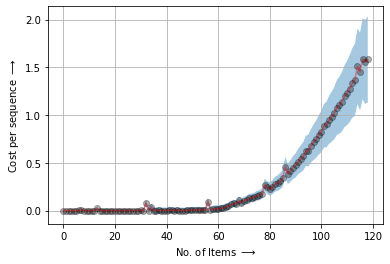

In [30]:
avgBSE = []
maxBSE = []
minBSE = []

y = []
for t in range(0,119):
    x=0
    for i in range(5):
        x += MultiBSEs[i][t]
        y.append(MultiBSEs[i][t])
    avgBSE.append(float(x/5))
    maxBSE.append(float(x/5 + np.std(y)))
    minBSE.append(float(x/5 - np.std(y)))

xr = [i for i in range(119)]
    
spl = make_interp_spline(xr, avgBSE, k=3)  # type: BSpline
power_smooth = spl(xr)

plt.plot(power_smooth,'o',color='black',alpha = 0.3)
plt.plot(power_smooth,alpha=0.4,color='red')
plt.fill_between(x = xr, y1 = minBSE, y2 = maxBSE,interpolate=True, alpha = 0.4)
# plt.plot(x=[10,10],y=[0,8.5])
plt.grid()
plt.xlabel('No. of Items $\longrightarrow$')
plt.ylabel('Cost per sequence $\longrightarrow$')
        
# plt.plot(MultiBSEs[0],'^',color='black',alpha = 0.7)
# plt.plot(MultiBSEs[0],alpha=0.4)
# # plt.plot(x=[10,10],y=[0,8.5])
# plt.grid()
# plt.xlabel('No. of Items $\longrightarrow$')
# plt.ylabel('Cost per sequence $\longrightarrow$')

plt.savefig('HigherBSEs.svg')
